# Difference in Differences with `pymc` models

:::{note}
This example is in-progress! Further elaboration and explanation will follow soon.
:::

In [1]:
import arviz as az

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Load data

In [3]:
df = cp.load_data("did")
df.head()

,group,t,unit,post_treatment,y
0,0,0.0,0,False,0.897122
1,0,1.0,0,True,1.961214
2,1,0.0,1,False,1.233525
3,1,1.0,1,True,2.752794
4,0,0.0,2,False,1.149207


## Run the analysis

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

In [4]:
result = cp.DifferenceInDifferences(
    df,
    formula="y ~ 1 + group*post_treatment",
    time_variable_name="t",
    group_variable_name="group",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


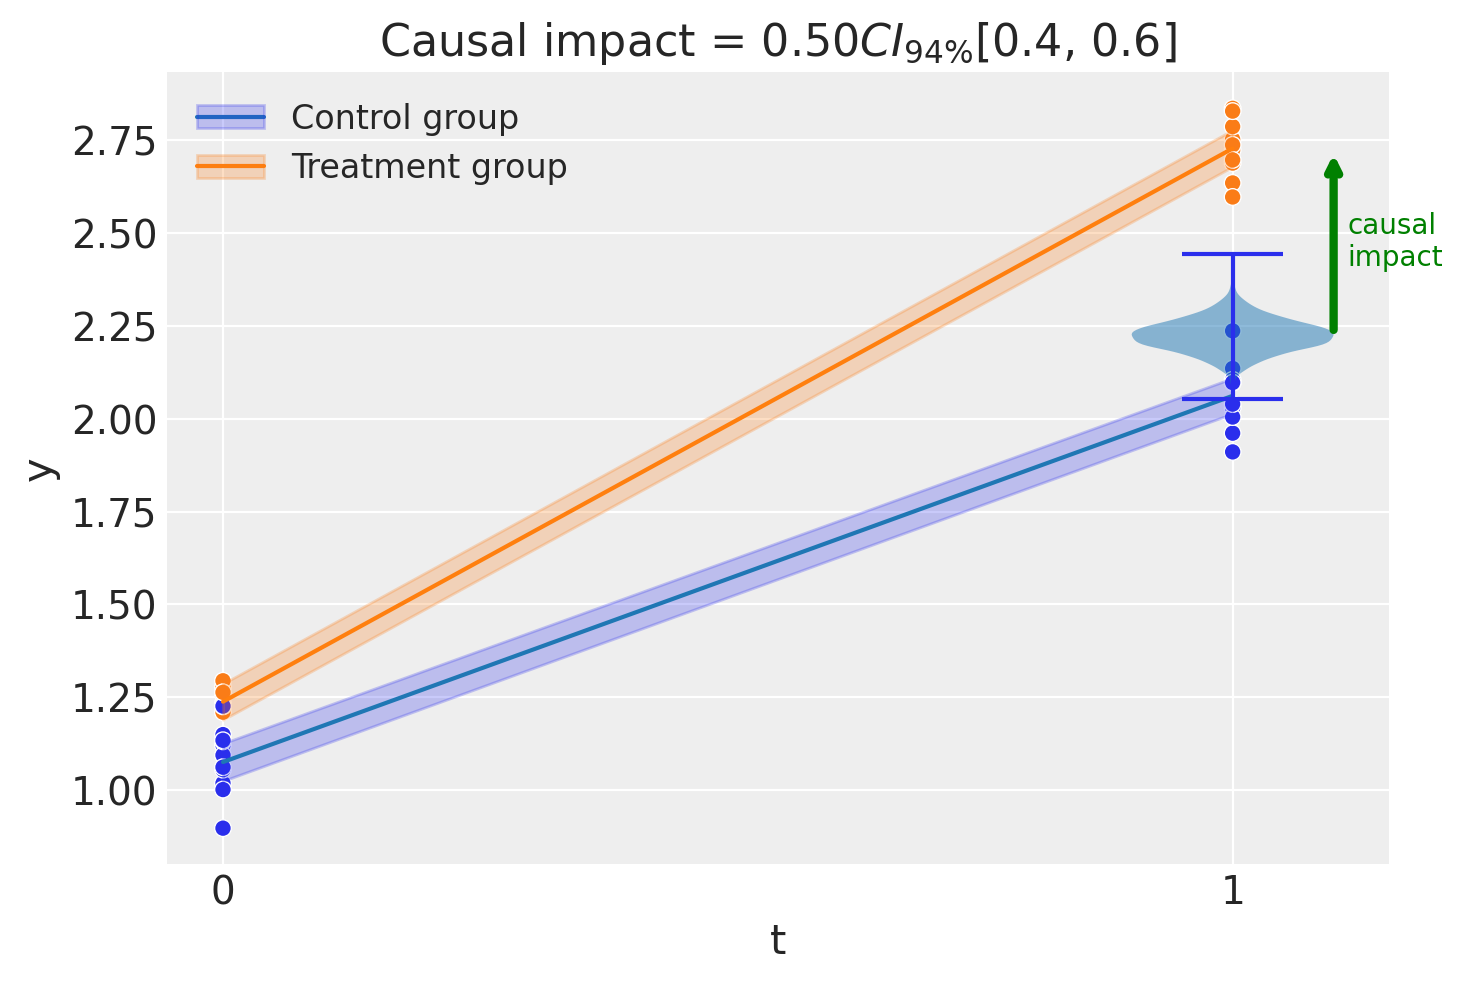

In [5]:
fig, ax = result.plot()

In [6]:
result.summary()

===========================Difference in Differences============================
Formula: y ~ 1 + group*post_treatment

Results:
Causal impact = 0.50$CI_{94\%}$[0.4, 0.6]
Model coefficients:
    Intercept                     1.1, 94% HDI [1, 1.1]
    post_treatment[T.True]        0.99, 94% HDI [0.92, 1.1]
    group                         0.16, 94% HDI [0.094, 0.23]
    group:post_treatment[T.True]  0.5, 94% HDI [0.4, 0.6]
    y_hat_sigma                   0.082, 94% HDI [0.066, 0.1]


In [7]:
ax = az.plot_posterior(result.causal_impact, ref_val=0)
ax.set(title="Posterior estimate of causal impact");

## Effect Summary Reporting

For decision-making, you often need a concise summary of the causal effect. The `effect_summary()` method provides a decision-ready report with key statistics. Note that for Difference-in-Differences, the effect is a single scalar (average treatment effect), unlike time-series experiments where effects vary over time.


In [8]:
# Generate effect summary
stats = result.effect_summary()

# Display the summary table
print(stats.table)
print("\n" + stats.text)

                      mean    median  hdi_lower  hdi_upper  p_gt_0
treatment_effect  0.503779  0.504367   0.401661   0.607651     1.0

The average treatment effect was 0.50 (95% HDI [0.40, 0.61]), with a posterior probability of an increase of 1.000.


You can customize the summary with different directions and ROPE thresholds:

- **Direction**: Test for increase, decrease, or two-sided effect
- **Alpha**: Set the HDI confidence level (default 95%)
- **ROPE**: Specify a minimal effect size threshold


In [9]:
# Example: Two-sided test with ROPE
stats = result.effect_summary(
    direction="two-sided",
    alpha=0.05,
    min_effect=0.3,  # Region of Practical Equivalence
)

print(stats.table)
print("\n" + stats.text)

                      mean    median  hdi_lower  hdi_upper  p_two_sided  \
treatment_effect  0.503779  0.504367   0.401661   0.607651          0.0   

                  prob_of_effect   p_rope  
treatment_effect             1.0  0.99925  

The average treatment effect was 0.50 (95% HDI [0.40, 0.61]), with a posterior probability of an effect of 1.000.
